In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture

## 1. Explore and Clean
### 1.1 clinical data
### 1.1.1 clean data

In [2]:
## clinical data
patient_data = pd.read_csv('patient_data.tsv',sep='\t',index_col=0).T.iloc[1:]
## change type to integer
patient_data['Diagnosis Age'] = patient_data['Diagnosis Age'].astype(int)
patient_data['Mutation Count'] = patient_data['Mutation Count'].astype(int)
patient_data["Overall Survival (Months)"] = patient_data["Overall Survival (Months)"].astype(float)


## transform ages into category
patient_data['Diagnosis Age 2'] = ''
patient_data.loc[patient_data['Diagnosis Age'] <= 40,'Diagnosis Age 2'] = 'youth'
patient_data.loc[(patient_data['Diagnosis Age'] > 40) & (patient_data['Diagnosis Age'] <= 55),'Diagnosis Age 2'] = 'mid age'
patient_data.loc[(patient_data['Diagnosis Age'] > 55),'Diagnosis Age 2'] = 'old age'

## filter data with nan in Grade and Vital Status
patient_data = patient_data[patient_data['Neoplasm Histologic Grade'].notnull()]
patient_data = patient_data[patient_data["Patient's Vital Status"].notnull()]

In [3]:
## remove cols with only unique value, '# Samples per Patient','Cancer Type' and 'Neoplasm Histologic Type Name'
## "Overall Survival Status" and "Patient's Vital Status" are same, so delete one
patient_data_2 = patient_data.drop(['# Samples per Patient','Cancer Type','Neoplasm Histologic Type Name',"Overall Survival Status"],1)

## fillna
patient_data_2 = patient_data_2.fillna("unknown")

## convert some features to binary
patient_data_2['Profiled in Mutations'] = (patient_data_2['Profiled in Mutations'] == 'Yes').astype(int)
patient_data_2['Profiled in Putative copy-number alterations from GISTIC'] = (patient_data_2['Profiled in Putative copy-number alterations from GISTIC'] == 'Yes').astype(int)
patient_data_2['Informed consent verified'] = (patient_data_2['Informed consent verified'] == 'Yes').astype(int)
patient_data_2["Patient's Vital Status"] = (patient_data_2["Patient's Vital Status"]== 'Alive').astype(int)

## one mispelling in Sex, so replace "MALE" with "Male"
patient_data_2["Sex"] = patient_data_2["Sex"].str.replace("MALE","Male")
patient_data_2["Sex"] = (patient_data_2["Sex"] == 'Male').astype(int)


In [4]:
patient_data_plot = patient_data_2.copy()
patient_data_plot.columns = ['Profiled in Mutations',
       'Profiled in copy-num alter',
       'Tumor Stage Code', 'Diagnosis Age',
       'Informed consent verified', 'Overall Survival (Months)',
       'Neoplasm Histologic Grade', 'Race Category', 'Sex',
       "Patient's Vital Status", 'Mutation Count', 'Diagnosis Age 2']

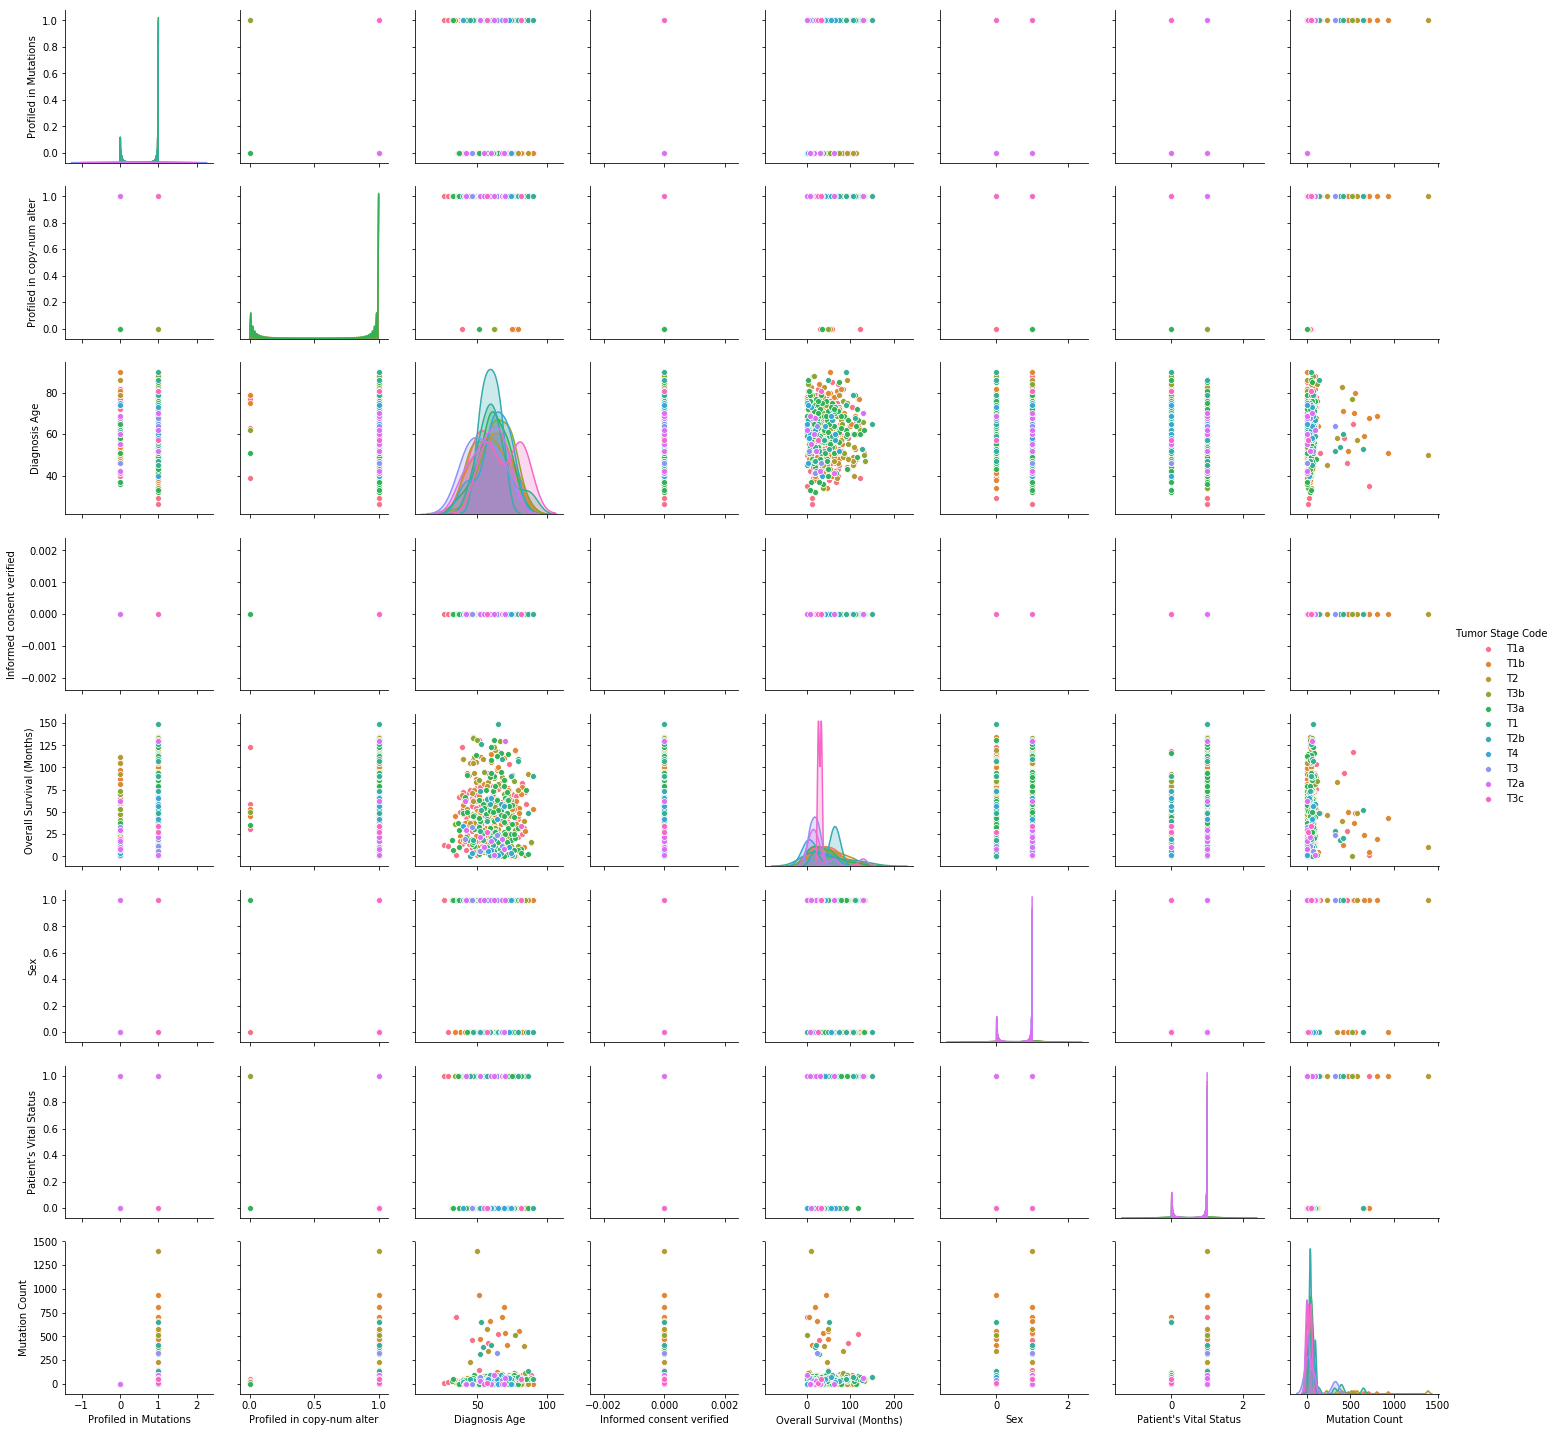

In [5]:
sns.pairplot(patient_data_plot,hue='Tumor Stage Code')

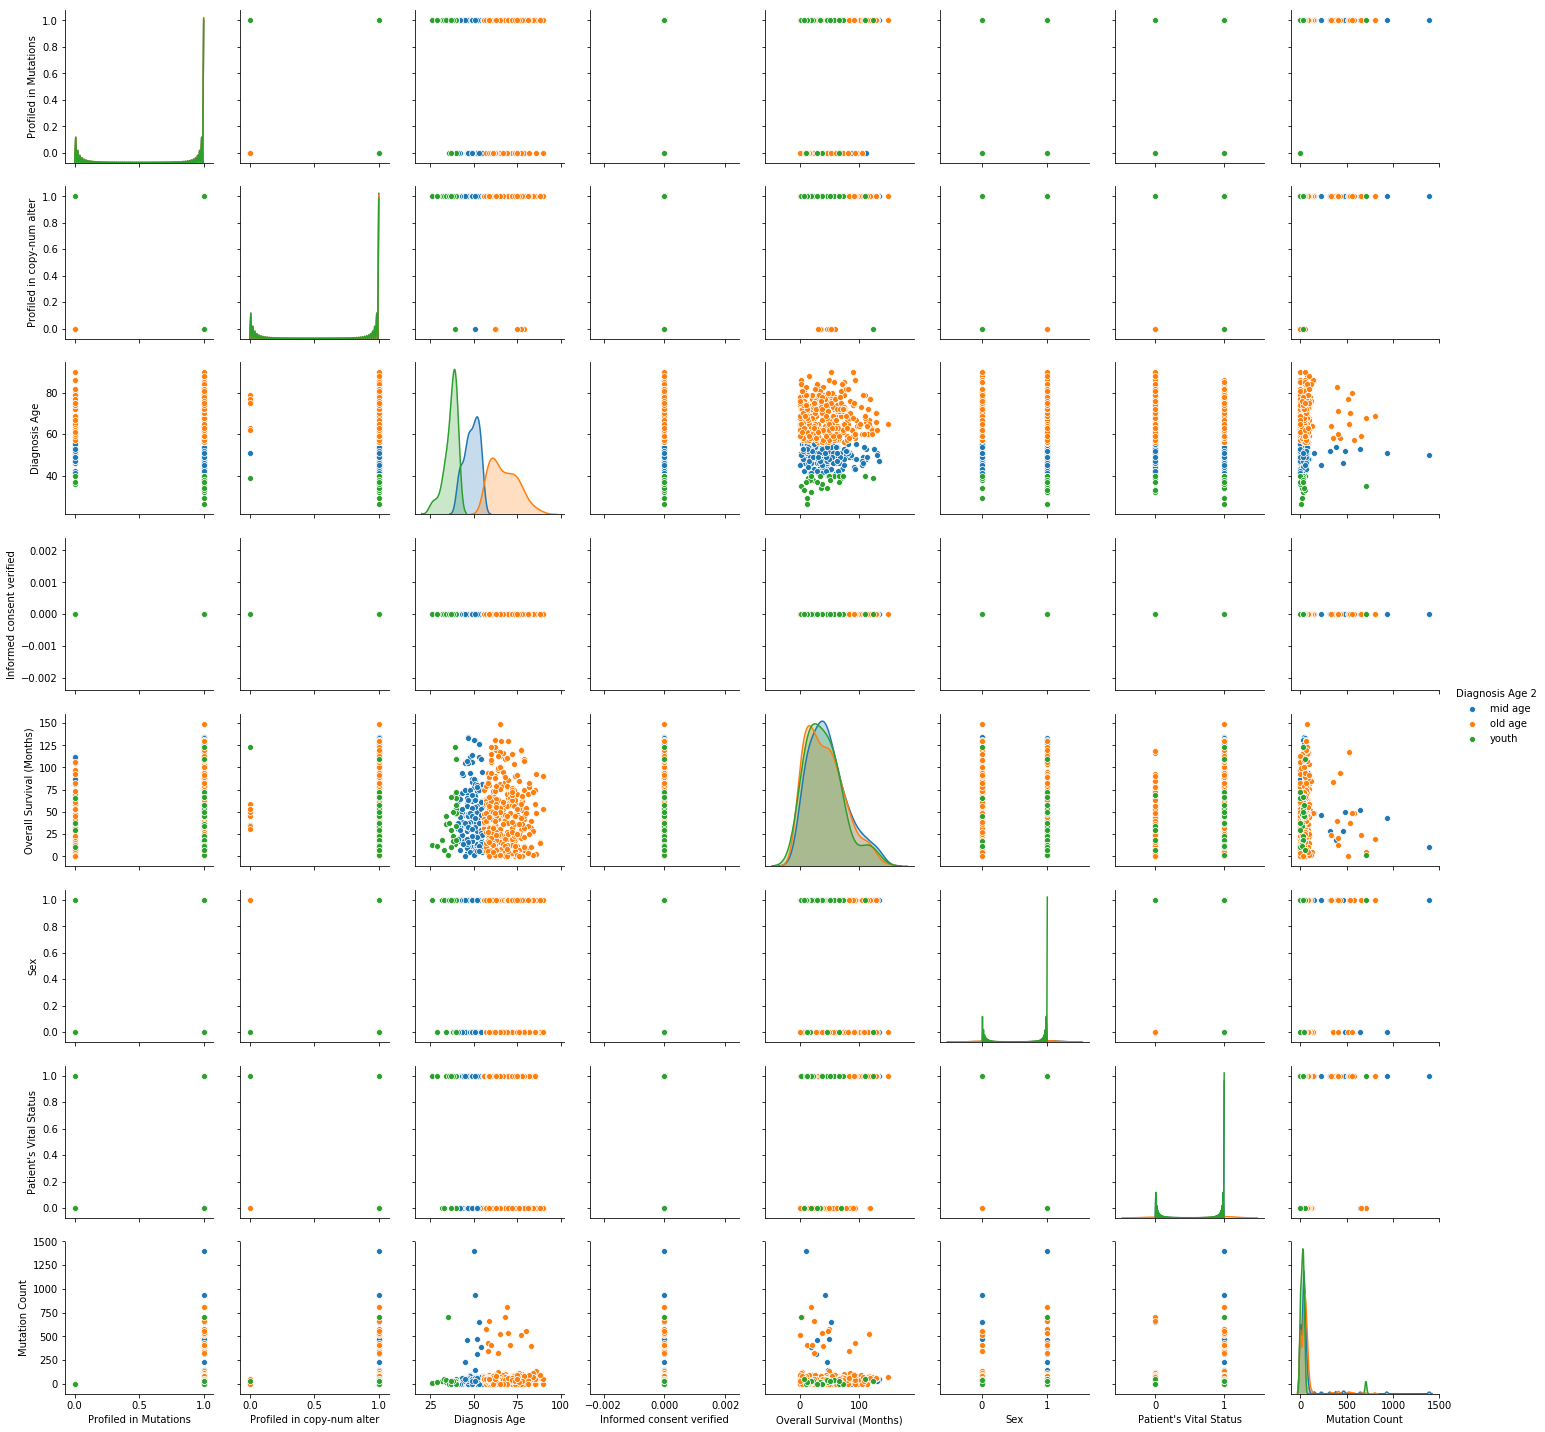

In [6]:
sns.pairplot(patient_data_plot,hue='Diagnosis Age 2')

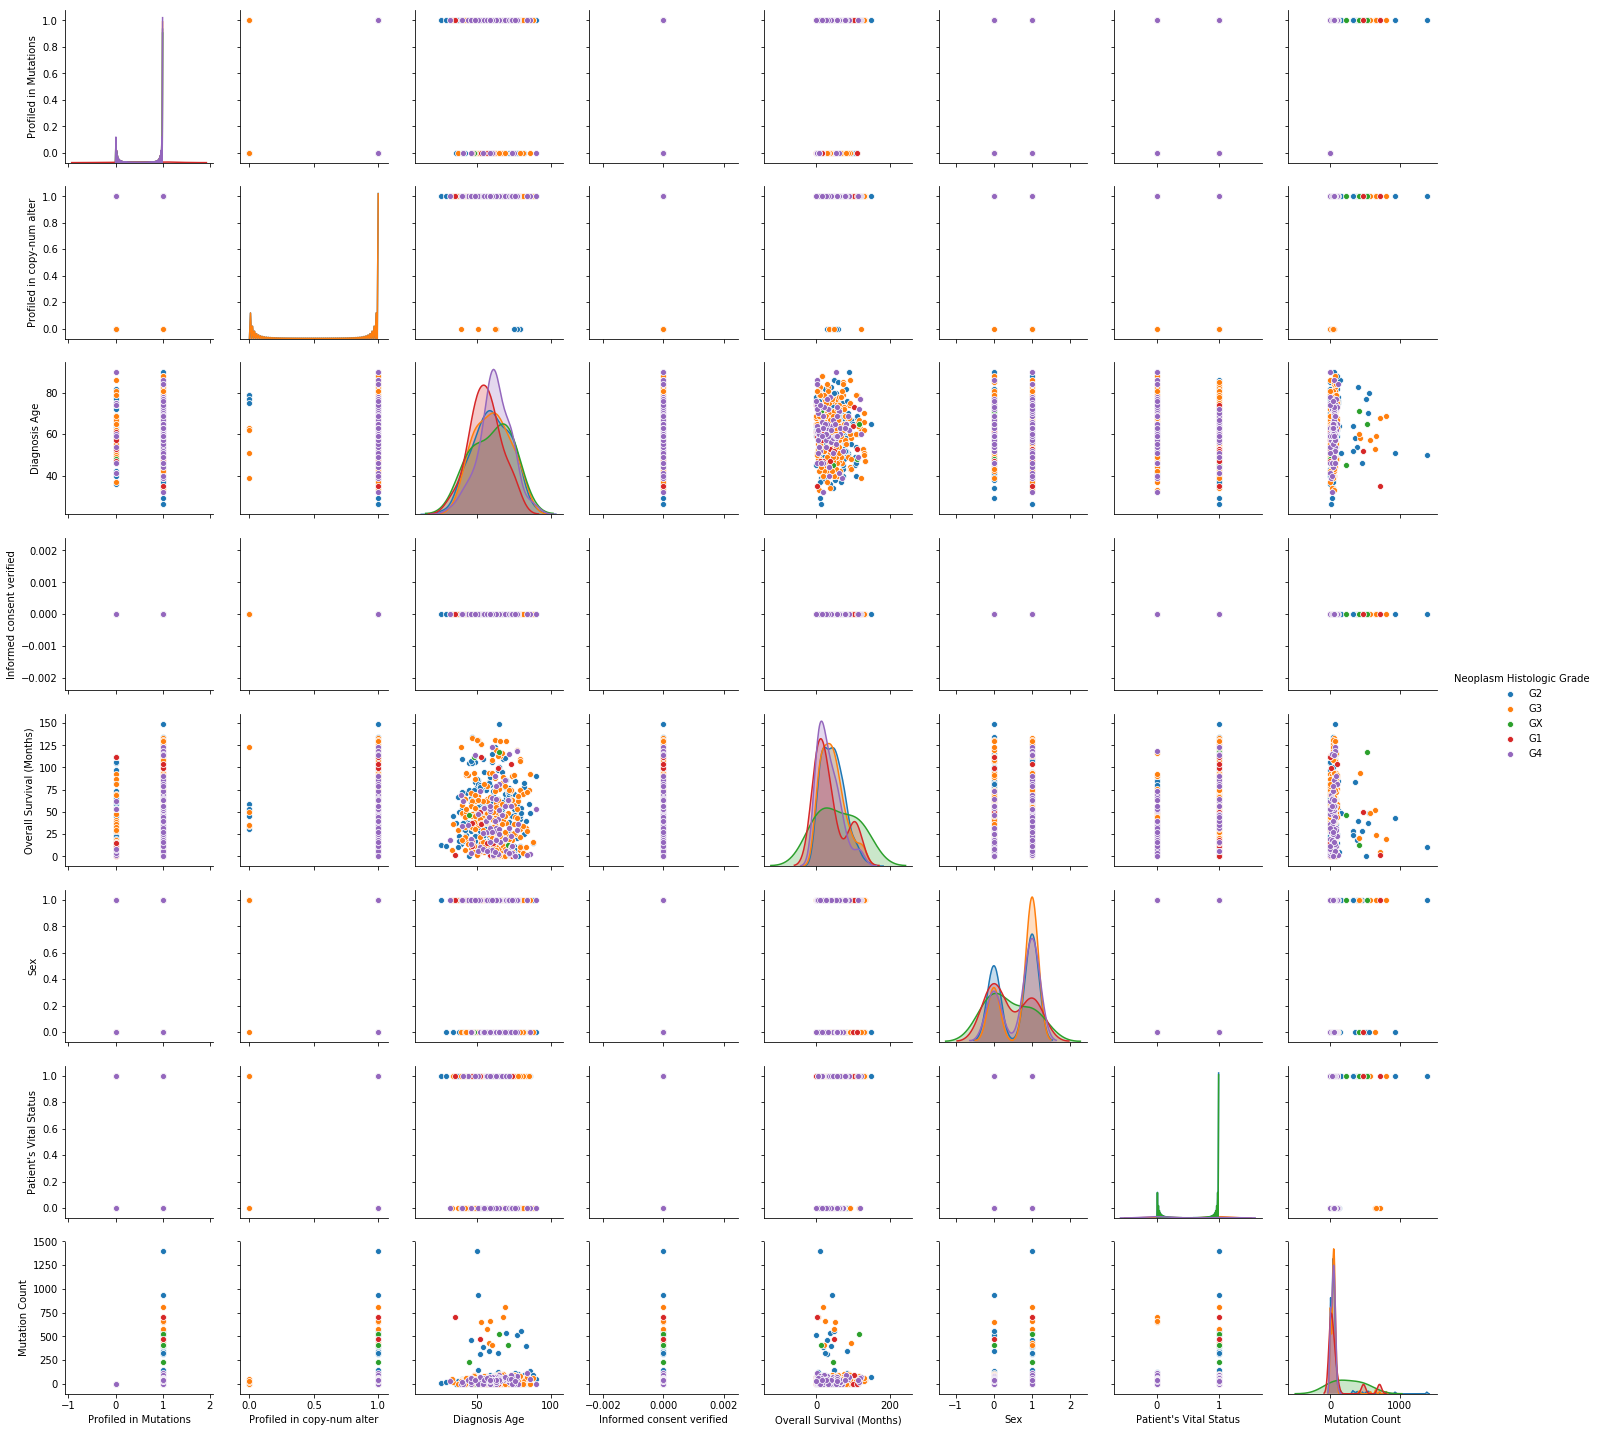

In [7]:
sns.pairplot(patient_data_plot,hue='Neoplasm Histologic Grade')

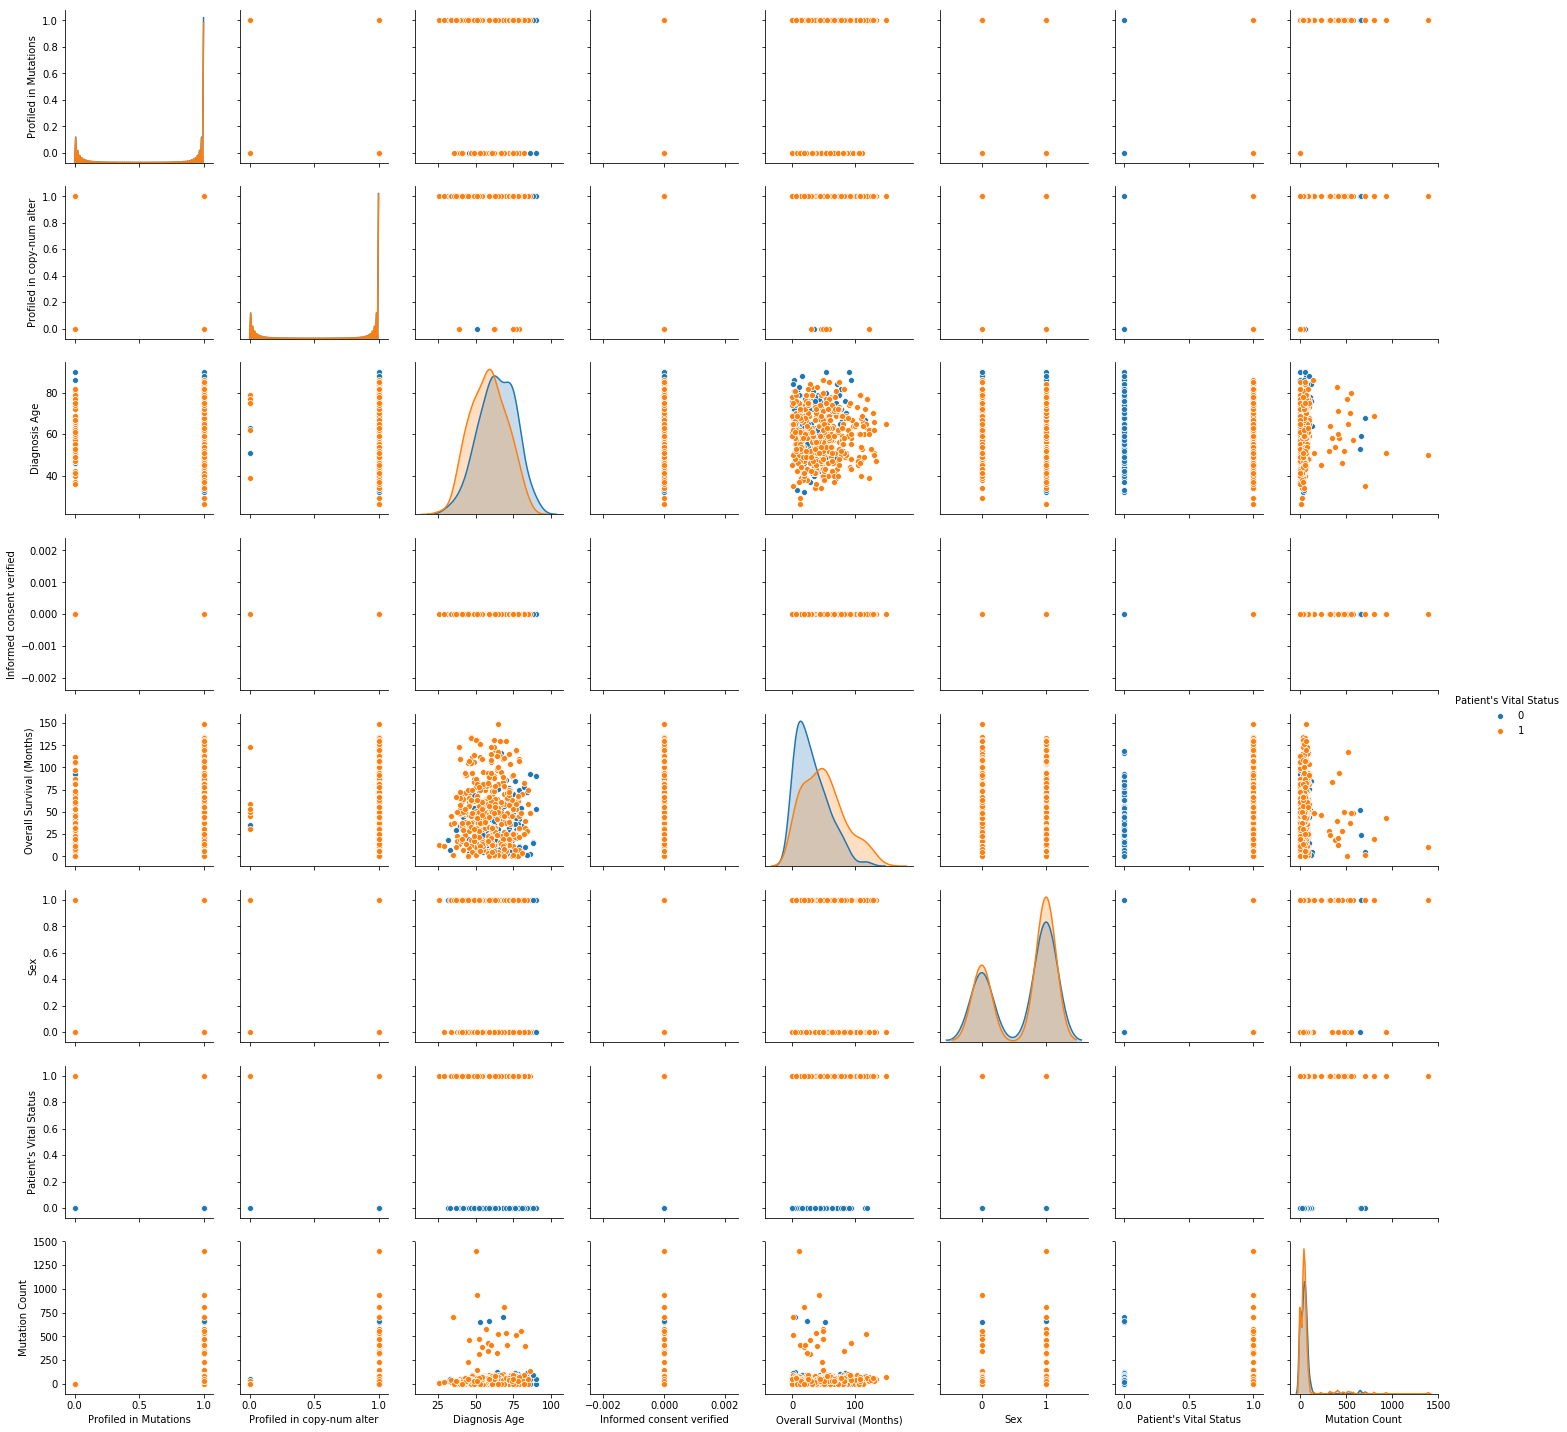

In [8]:
sns.pairplot(patient_data_plot,hue="Patient's Vital Status")

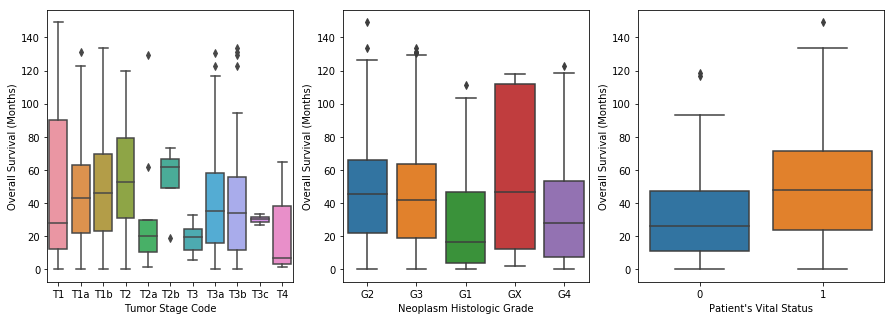

In [9]:
patient_data_plot2 = patient_data_plot
patient_data_plot2 = patient_data_plot2.sort_values('Tumor Stage Code')#.sort_values('Neoplasm Histologic Grade')

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.boxplot(x=patient_data_plot2['Tumor Stage Code'],y=patient_data_plot2['Overall Survival (Months)'])
plt.subplot(1, 3, 2)
sns.boxplot(x=patient_data_plot2['Neoplasm Histologic Grade'],y=patient_data_plot2['Overall Survival (Months)'])
plt.subplot(1, 3, 3)
sns.boxplot(x=patient_data_plot2["Patient's Vital Status"].astype(str),y=patient_data_plot2['Overall Survival (Months)'])

In [10]:
patient_data_target = patient_data_2[['American Joint Committee on Cancer Tumor Stage Code','Overall Survival (Months)',"Patient's Vital Status","Neoplasm Histologic Grade"]]
patient_data_target['American Joint Committee on Cancer Tumor Stage Code'] = patient_data_target['American Joint Committee on Cancer Tumor Stage Code'].str.replace("a","").str.replace("b","").str.replace("c","")
Stage = pd.get_dummies(patient_data_target['American Joint Committee on Cancer Tumor Stage Code'])#.iloc[:,1:]
Grade = pd.get_dummies(patient_data_target['Neoplasm Histologic Grade'])#.iloc[:,:-1]

patient_data_target2 = pd.concat([patient_data_target[["Overall Survival (Months)","Patient's Vital Status"]],Stage,Grade],1)


In [11]:
# mm = GaussianMixture(n_components=3,covariance_type='tied',max_iter=2000)

# patient_data_target2_c = patient_data_target2.copy()
# patient_data_target2_c['classes'] = mm.fit_predict(patient_data_target2_c)
# sns.boxplot(y="Overall Survival (Months)",x="classes",data=patient_data_target2_c)
# patient_data_target2_c.groupby("classes").mean()

## 1.1.2 Unsupervised clustering for categories of risks

,Overall Survival (Months),Patient's Vital Status,T1,T2,T3,T4,G1,G2,G3,G4,GX
classes,,,,,,,,,,,
0,14.580142,0.535545,0.459716,0.099526,0.393365,0.047393,0.052133,0.374408,0.355450,0.203791,0.014218
1,44.670848,0.696970,0.551515,0.115152,0.327273,0.006061,0.000000,0.466667,0.412121,0.121212,0.000000
2,85.959139,0.841060,0.543046,0.185430,0.271523,0.000000,0.019868,0.470199,0.410596,0.086093,0.013245


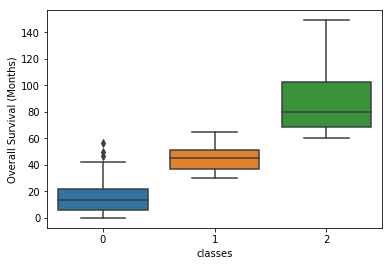

In [12]:
patient_data_target4 = patient_data_target2.copy()

## add a col for indicating length of Survival Months as short, med, long.
## short, med, long was assigned based on 1d clustering of "Overall Survival (Months)" using GaussianMixture.
patient_data_target4['Survival_len'] = ""
patient_data_target4.loc[patient_data_target4["Overall Survival (Months)"] < 30,"Survival_len"] = "short"
patient_data_target4.loc[patient_data_target4["Overall Survival (Months)"] >= 60,"Survival_len"] = "long"
patient_data_target4.loc[(patient_data_target4["Overall Survival (Months)"] >= 30) & (patient_data_target4["Overall Survival (Months)"] < 60),"Survival_len"] = "med"

patient_data_target4_t = pd.concat([patient_data_target4.iloc[:,:-1],pd.get_dummies(patient_data_target4['Survival_len'])],1)

mm = GaussianMixture(n_components=3,covariance_type='full',max_iter=2000)
patient_data_target4['classes'] = mm.fit_predict(patient_data_target4_t)
sns.boxplot(y="Overall Survival (Months)",x="classes",data=patient_data_target4)
patient_data_target4_mean = patient_data_target4.groupby("classes").mean()
patient_data_target4_mean

In [13]:
# patient_data_target4.groupby("Survival_len").mean()

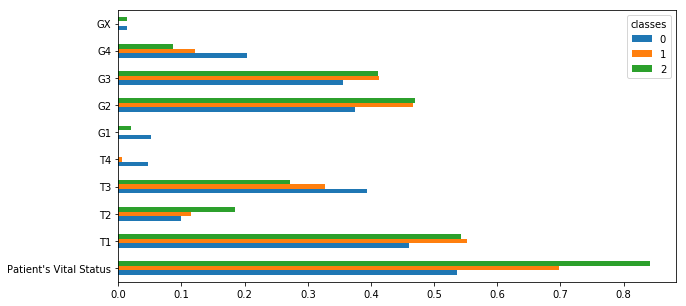

In [14]:
patient_data_target4_mean.iloc[:,1:].T.plot.barh(rot=0,figsize=(10,5))

In [15]:
patient_data_target4.groupby("classes").size()

classes
0    211
1    165
2    151
dtype: int64

In [16]:
patient_data_target.groupby("Neoplasm Histologic Grade").size()

Neoplasm Histologic Grade
G1     14
G2    227
G3    205
G4     76
GX      5
dtype: int64

In [17]:
patient_data_target.groupby("American Joint Committee on Cancer Tumor Stage Code").size()

American Joint Committee on Cancer Tumor Stage Code
T1    270
T2     68
T3    178
T4     11
dtype: int64

In [18]:
patient_data_target4.groupby("classes").size()

classes
0    211
1    165
2    151
dtype: int64

In [19]:
patient_data_target4.head()
patient_data_target4['classes'] = patient_data_target4['classes'].astype(str).replace("0","high").replace("1","medium").replace("2","low")

In [20]:
patient_data_3 = patient_data_2.drop(["American Joint Committee on Cancer Tumor Stage Code","Overall Survival (Months)","Neoplasm Histologic Grade","Patient's Vital Status","Diagnosis Age"],1)
patient_data_3 = pd.concat([patient_data_3,patient_data_target4[["classes"]]],1)
patient_data_3.to_csv("modify_patient_data.csv")

In [437]:
patient_data_target_tem = patient_data_target.copy()
patient_data_target_tem['Neoplasm Histologic Grade'] = patient_data_target_tem['Neoplasm Histologic Grade'].str.replace("G","").str.replace("X","0").astype(int)
patient_data_target_tem['American Joint Committee on Cancer Tumor Stage Code'] = patient_data_target_tem['American Joint Committee on Cancer Tumor Stage Code'].str.replace("T","").astype(int)

#patient_data_target_tem2[:,0] = patient_data_target_tem2[:,0]/3
# mm = GaussianMixture(n_components=3,covariance_type='spherical',max_iter=2000)
# patient_data_target_tem['classes'] = mm.fit_predict(patient_data_target_tem2)
# sns.boxplot(y="Overall Survival (Months)",x="classes",data=patient_data_target_tem)
# patient_data_target4_mean = patient_data_target_tem.groupby("classes").mean()
# patient_data_target4_mean

scaler = StandardScaler()
patient_data_target_tem2 = scaler.fit_transform(patient_data_target_tem)
patient_data_target_tem2 = pd.DataFrame(patient_data_target_tem2)
patient_data_target_tem2.columns = patient_data_target_tem.columns
patient_data_target_tem2.index = patient_data_target_tem.index

patient_data_target_tem2['Overall Survival (Months)'] = patient_data_target_tem2['Overall Survival (Months)']
patient_data_target_tem2["Neoplasm Histologic Grade"] = patient_data_target_tem2["Neoplasm Histologic Grade"]
patient_data_target_tem2["American Joint Committee on Cancer Tumor Stage Code"] = patient_data_target_tem2["American Joint Committee on Cancer Tumor Stage Code"] 
patient_data_target_tem2["Patient's Vital Status"] = patient_data_target_tem2["Patient's Vital Status"] * 0.9

patient_data_target_tem2.corr(method="spearman")

track_name,American Joint Committee on Cancer Tumor Stage Code,Overall Survival (Months),Patient's Vital Status,Neoplasm Histologic Grade
track_name,,,,
American Joint Committee on Cancer Tumor Stage Code,1.000000,-0.115702,-0.356635,0.444113
Overall Survival (Months),-0.115702,1.000000,0.276028,-0.083235
Patient's Vital Status,-0.356635,0.276028,1.000000,-0.369101
Neoplasm Histologic Grade,0.444113,-0.083235,-0.369101,1.000000


track_name,American Joint Committee on Cancer Tumor Stage Code,Overall Survival (Months),Patient's Vital Status,Neoplasm Histologic Grade
classes,,,,
0,1.385294,50.616912,0.900000,2.261765
1,2.743316,33.246952,0.262032,3.304813


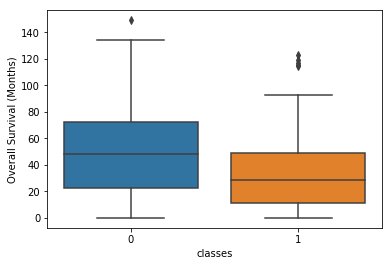

In [480]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2,max_iter=3000)
km.fit_predict(patient_data_target_tem2)
#mm = GaussianMixture(n_components=2,covariance_type='full',max_iter=4000)
patient_data_target_tem['classes'] = km.fit_predict(patient_data_target_tem2)

#patient_data_target_tem['classes'] = mm.fit_predict(patient_data_target_tem2)
sns.boxplot(y="Overall Survival (Months)",x="classes",data=patient_data_target_tem)
patient_data_target4_mean = patient_data_target_tem.groupby("classes").mean()
patient_data_target4_mean

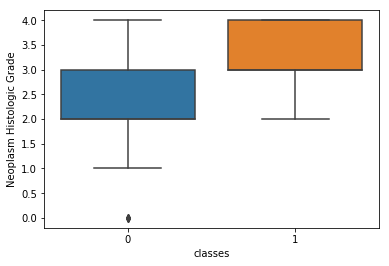

In [481]:
sns.boxplot(y="Neoplasm Histologic Grade",x="classes",data=patient_data_target_tem)

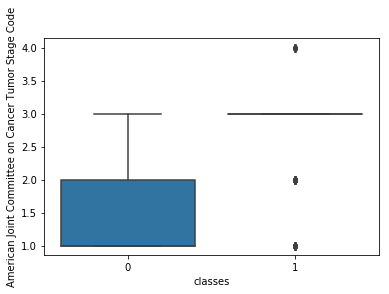

In [482]:
sns.boxplot(y="American Joint Committee on Cancer Tumor Stage Code",x="classes",data=patient_data_target_tem)

In [483]:
patient_data_target_tem.groupby("classes").size()

classes
0    340
1    187
dtype: int64

In [491]:
patient_data_4 = patient_data_3.copy()
patient_data_4['classes'] = patient_data_target_tem['classes'].astype(str).str.replace("0",'low').str.replace("1",'high')
patient_data_4.to_csv("modify_patient_data_2.csv")

### 1.2 RNAseq Data

Explained variance:
[0.70837994 0.05510873 0.03907801 0.03487464 0.03421484 0.00805064
 0.00696276 0.00653205 0.0059551  0.00542363]


Text(0, 0.5, 'PC2 5.51% explained variance')

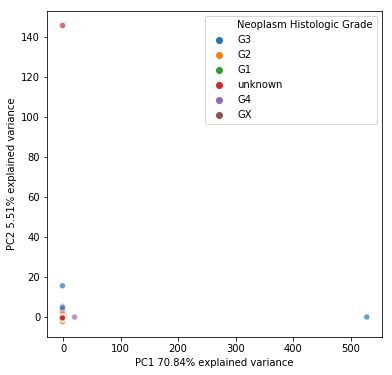

In [830]:
# Figure 1
# PCA visualization of Original Data 
## input mrna data
mrna_data = pd.read_csv("mrna_data.txt",sep='\t',index_col=1).iloc[:,1:]
mrna_data = mrna_data.dropna(1,how='all') ## drop col full of nan

pca = PCA(n_components=10)
pca.fit(mrna_data)
mrnA_pca = pca.transform(mrna_data)

mrnA_pca = pd.DataFrame(mrnA_pca)
#mrnA_pca.index = ind
#print(mrnA_pca)

## explained var
explained_var = pca.explained_variance_ratio_
print("Explained variance:")
print(explained_var)

## temporarily merge mRNA and clinical data for plot
patient_data_tem = patient_data_plot.copy()
patient_data_tem['merge'] = patient_data_tem.index
patient_data_tem['merge'] = patient_data_tem['merge'] + '-01'

mrnA_pca.index = mrna_data.index
merge_tem_plot = pd.merge(mrnA_pca,patient_data_tem,left_index=True,right_on='merge',how='left').fillna("unknown")


## PCA plot 
plt.figure(figsize=(6,6))
sns.scatterplot(x=0, y=1, data=merge_tem_plot,hue='Neoplasm Histologic Grade',alpha=0.7)
plt.xlabel("PC1 {:0.2f}% explained variance".format(explained_var[0] *100))
plt.ylabel("PC2 {:0.2f}% explained variance".format(explained_var[1] *100))


% of outliers:
10.11%
Explained variance:
[0.70837994 0.05510873 0.03907801 0.03487464 0.03421484 0.00805064
 0.00696276 0.00653205 0.0059551  0.00542363]


Text(0, 0.5, 'PC2 5.51% explained variance')

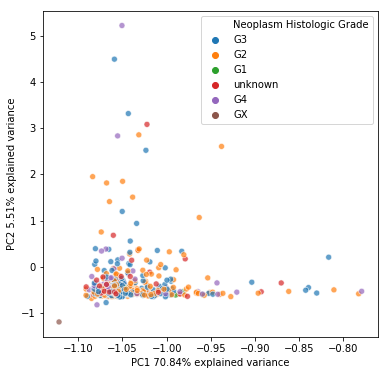

In [832]:
# fit the model
clf = IsolationForest(n_estimators=400)
clf.fit(mrna_data)

mrnA_pca_outlier = clf.predict(mrna_data)
outlier_per = 1 - np.mean(mrnA_pca_outlier == 1)

print("% of outliers:")
print("{:0.2f}%".format(outlier_per*100))

mrna_data_rmout = mrna_data[(mrnA_pca_outlier == 1)]

pca_rmout = PCA(n_components=10)
pca_rmout.fit(mrna_data)

mrna_data_rmout_pca = pca_rmout.transform(mrna_data_rmout)
mrna_data_rmout_pca = pd.DataFrame(mrna_data_rmout_pca)

## explained var
rmout_explained_var = pca.explained_variance_ratio_
print("Explained variance:")
print(rmout_explained_var)

mrna_data_rmout_pca.index = mrna_data_rmout.index
merge_tem_plot2 = pd.merge(mrna_data_rmout_pca,patient_data_tem,left_index=True,right_on='merge',how='left').fillna("unknown")
merge_tem_plot2

plt.figure(figsize=(6,6))
sns.scatterplot(x=0,y=1,data=merge_tem_plot2,hue='Neoplasm Histologic Grade',alpha=0.7)

plt.xlabel("PC1 {:0.2f}% explained variance".format(explained_var[0] *100))
plt.ylabel("PC2 {:0.2f}% explained variance".format(explained_var[1] *100))

### There are some examples with certain number of genes that were overexpressed.
### These outliers that differs significantly from other observations could be caused from variability in the measurement or sequencing/sampling error. The outliers will affect performance of the models we built. So we remove outlier using IsolationForest, which was based on random forest and robust to high dimensionalities. 

In [836]:
mrna_data_rmout.to_csv("modify_mrna_data.csv")

## 1.3 Mutation data

In [1336]:
from Bio.SubsMat import MatrixInfo
blosum62 = MatrixInfo.blosum62
blosum62_2 = {(key[1],key[0]):value for key,value in blosum62.items()}
blosum62.update(blosum62_2)

seq_data = pd.read_csv("seq_data.txt",sep="\t",index_col=1).iloc[:,1:]

## remove cols with all nan. totally 53 genes were removed.
seq_data = seq_data.dropna(1,how='all')

## replace annotation of mutation with blosum62 penalty socre
shape = seq_data.shape 
for i in range(shape[0]):
    for j in range(shape[1]):
        if not (seq_data.iloc[i,j] != seq_data.iloc[i,j]):
            #print(seq_data.iloc[i,j])
            if "*" in seq_data.iloc[i,j]:
                seq_data.iloc[i,j] = -20
            elif "_splice"in seq_data.iloc[i,j] or "="in seq_data.iloc[i,j]:
                seq_data.iloc[i,j] = -10
            else:
                eachs = seq_data.iloc[i,j].split(" ")
                keys = [(each[0],each[-1]) for each in eachs]
                seq_data.iloc[i,j] = np.sum([blosum62[key] for key in keys])

seq_data2 = seq_data.fillna(0)

In [1338]:
## Mutation:1, No mutation:0
## Because data is already very sparse
## didn't try using get_dummy in order to avoid more sparse


In [1339]:
# ## merge 3 files
# mrna_seq = pd.merge(mrna_data_rmout,seq_data2,left_index=True,right_index=True)

# clin_mrna_seq = pd.merge(patient_data_2,mrna_seq,left_on='merge',right_index=True)
# clin_mrna_seq = clin_mrna_seq.drop('merge',1)

In [1340]:
seq_data2.to_csv("modify_seq_data.csv")